In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from logistic import LogisticRegression, GradientDescentOptimizer
# , NewtonOptimizer

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

In [5]:
# from perceptron lecture

def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

In [6]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

In [7]:
def train_LR(X, y, alpha, beta, num_steps=100): 
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)

    # initialize for main loop
    loss = 1
    loss_vec = []
    weight_vec = [torch.rand(X.size()[1])]
    iter =  0

    for _ in range(num_steps):
        # add other stuff to e.g. keep track of the loss over time. 

        prev_loss = loss
        loss = LR.loss(X, y)

        # old_w = torch.tensor([0, 0]) if LR.w == None else torch.clone(LR.w)

        opt.step(X, y, alpha, beta)

        if (prev_loss != loss):
            loss_vec.append(loss)
            weight_vec.append(LR.w)
    return LR, (loss_vec, weight_vec)

In [8]:
# plots the first and last 5 iterations of the decision boundary
def plot_decisions(X, y, weight_vec, loss_vec):
        # set up the figure
        current_ax = 0
        plt.rcParams["figure.figsize"] = (10, 8)
        fig, axarr = plt.subplots(2, 5, sharex = True, sharey = True)

        # iter through weight_vec

        for i in range(5):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        
        for i in range(len(weight_vec) - 6, len(weight_vec) - 1):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1

In [9]:
def plot_loss(loss_vec):
    plt.plot(loss_vec, color = "slategrey")
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
    labs = plt.gca().set(xlabel = "LR Iteration (Updates Only)", ylabel = "loss")

In [10]:
LR, (loss_vec, weight_vec) = train_LR(X, y, 0.1, 0.0, num_steps=100)

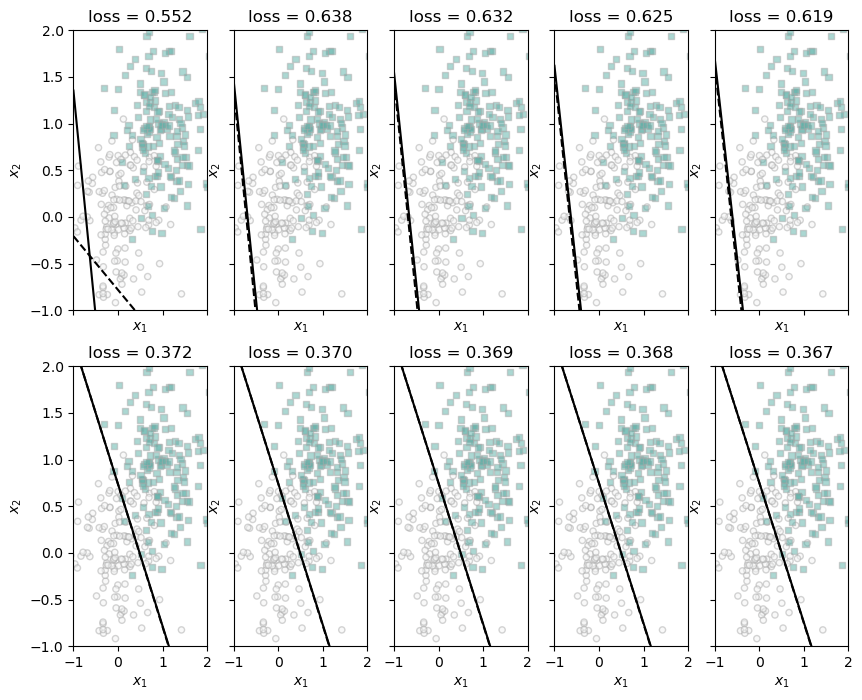

In [11]:
plot_decisions(X, y, weight_vec, loss_vec)

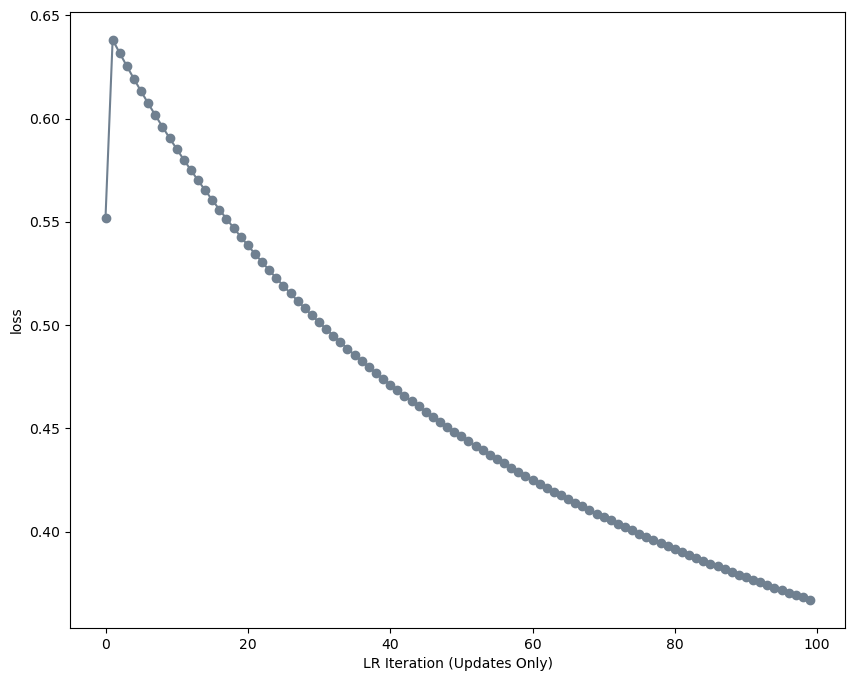

In [12]:
plot_loss(loss_vec)

In [13]:
LR, (loss_vec, weight_vec) = train_LR(X, y, 0.1, 0.9, num_steps=100)

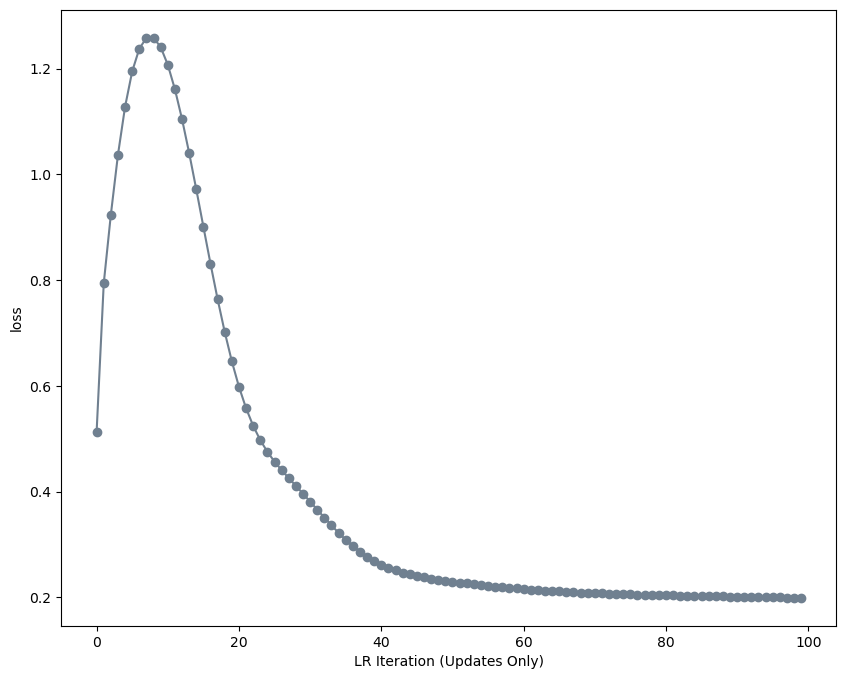

In [14]:
plot_loss(loss_vec)

In [15]:
X_train, y_train = classification_data(p_dims = 100, n_points = 50)
X_test, y_test = classification_data(p_dims = 100, n_points = 50)

In [16]:
LR, (loss_vec, weight_vec) = train_LR(X_train, y_train, 0.00001, 0.2)
loss_vec

c:\Users\Jeff\Desktop\CS\451\Logistic\logistic.py:59: RuntimeWarning: divide by zero encountered in log
  return torch.mean(-y*np.log(self.sigmoid(s)) - (1 - y) * np.log(1 - self.sigmoid(s)))


[tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tenso

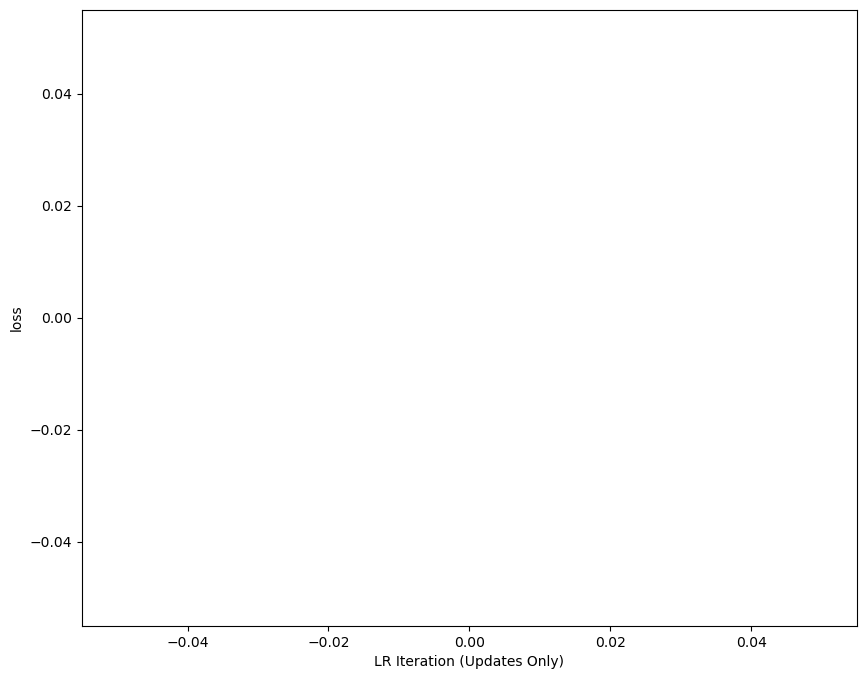

In [17]:
plot_loss(loss_vec)